In [195]:
%matplotlib inline
import pandas as pd
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

# Adjust display settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_colwidth', 120) # Make DataFrame column with wide enough to support pipedrive link...

**Merging the datasets and cleaning the data**

In [196]:
# Data: MovieLens _ml
# Read in Movies and Ratings from MovieLens Data
data_dir = '/home/justin/Documents/Data Science/Data'
mov_ml = pd.read_csv(data_dir + '/MovieLens/ml-latest/movies.csv')
rat_ml = pd.read_csv(data_dir + '/MovieLens/ml-latest/ratings.csv')

# Convert out of 5 ratings, to out of 10 ratings
rat_ml['rating'] = rat_ml['rating'] * 2

In [197]:
# Data: MovieLens _ml
# Find the average movie rating and store in 'mr', remove those without a rating
mov_rat_ml = pd.DataFrame(rat_ml[['movieId','rating']].groupby('movieId').mean())
mov_rat_ml.head()

,rating
movieId,
1,7.789603
2,6.442171
3,6.360189
4,5.759455
5,6.161622


In [198]:
# Data: MovieLens _ml
# Count the number of ratings and store in 'mc'. Sort by highest number of ratings first
mov_num_rat_ml = pd.DataFrame(rat_ml[['movieId','rating']].groupby('movieId').size(), columns=['num_ratings']).sort_values(by='num_ratings', ascending=0)
mov_num_rat_ml.head()

,num_ratings
movieId,
356,81296
296,79091
318,77887
593,76271
480,69545


In [199]:
# Data: MovieLens
# Show all movies, number of ratings 'num_ratings' and average rating 'rating'
mov_rat_agg_ml = mov_num_rat_ml.merge(mov_rat_ml, right_index=1, left_index=1)
mov_rat_agg_ml.head()

,num_ratings,rating
movieId,,
1,60424,7.789603
2,23950,6.442171
3,15267,6.360189
4,2935,5.759455
5,14769,6.161622


In [200]:
# Data: MovieLens _ml
# Aggregate all movies, and ratings stats into one Dataframe (Note: this removes unrated films)
# Sort by top movies if sorted by average rating, then number of ratings
agg_ml = (mov_ml.merge(mov_rat_agg_ml,how='inner', left_on='movieId',right_index=1).groupby(['title','genres']).mean().
    sort_values(['rating','num_ratings'], ascending=[0,0]))
agg_ml.reset_index(inplace=True)
agg_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33664 entries, 0 to 33663
Data columns (total 5 columns):
title          33664 non-null object
genres         33664 non-null object
movieId        33664 non-null float64
num_ratings    33664 non-null float64
rating         33664 non-null float64
dtypes: float64(3), object(2)
memory usage: 1.3+ MB


In [201]:
# Data: MovieLens
# Separate the year from the title into separate columns for MovieLens titles
df = agg_ml.copy()
df['year'] = df.title.str.extract('[(](\d{4})[)]') 
df['title'] = df.title.str.replace(r' [(]\d{4}[)]', '')
df['year'].fillna('0', inplace=True)
df['year'] = df['year'].astype(int)
agg_sepYr_ml = df
df.head()

,title,genres,movieId,num_ratings,rating,year
0,De la servitude moderne,Documentary,106517.0,2.0,10.0,2009
1,Dilwale,Action|Children|Comedy|Crime|Drama|Romance,150268.0,2.0,10.0,2015
2,Naked Among Wolves,Drama|War,148030.0,2.0,10.0,2015
3,The Fruit Hunters,Documentary,133323.0,2.0,10.0,2012
4,The Girl in the Book,Drama,148701.0,2.0,10.0,2015


In [202]:
# Data: MovieLens
# Move the 'The' to the start for MovieLens titles to help with matching
# (e.g. "Usual Suspects, The" in MovieLens is "The Usual Suspects" in IMDB & OMDB)
df = agg_sepYr_ml.copy()
df['has_the'] = df.title.str.contains(', The')
df.title = df.title.str.replace(r', The', '')
df.ix[df.has_the, 'title'] = 'The ' + df.ix[df.has_the, 'title']
agg_sepYr_moveThe_ml = df
df[df.has_the].head()

,title,genres,movieId,num_ratings,rating,year,has_the
42,The Barchester Chronicles,Drama,95517.0,1.0,10.0,1982,True
43,The Best of Ernie and Bert,Children,94972.0,1.0,10.0,1988,True
115,The Keeping the Promise (Sign of the Beaver),Children|Drama,93967.0,1.0,10.0,1997,True
142,The New Rulers of the World,Documentary,114011.0,1.0,10.0,2001,True
143,The On Any Sunday Next Chapter,Documentary,133964.0,1.0,10.0,2014,True


In [203]:
agg_sepYr_moveThe_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33664 entries, 0 to 33663
Data columns (total 7 columns):
title          33664 non-null object
genres         33664 non-null object
movieId        33664 non-null float64
num_ratings    33664 non-null float64
rating         33664 non-null float64
year           33664 non-null int64
has_the        33664 non-null bool
dtypes: bool(1), float64(3), int64(1), object(2)
memory usage: 1.6+ MB


In [204]:
# Data: MovieLens
# Move the 'A' to the start for MovieLens titles to help with matching
# (e.g. )
df = agg_sepYr_moveThe_ml.copy()
df['has_a'] = df.title.str.contains(', A')
df.title = df.title.str.replace(r', A', '')
df.ix[df.has_a, 'title'] = 'A ' + df.ix[df.has_a, 'title']
agg_sepYr_moveThe_moveA_ml = df
df[df.has_a].head()

,title,genres,movieId,num_ratings,rating,year,has_the,has_a
57,A Christmasgain,(no genres listed),148857.0,1.0,10.00,2015,False,True
305,A Child's Christmas in Wales,Children|Drama,95837.0,4.0,9.25,1987,False,True
323,A Season for Miracles,Children|Romance,98699.0,3.0,9.00,1999,False,True
343,A Fine Madness,Comedy|Drama|Romance,31638.0,2.0,9.00,1966,False,True
454,A Englishugust,Comedy|Drama,139895.0,1.0,9.00,1994,False,True


In [206]:
# Function to normalise title names, by removing : and - and making titles in "Title Case Which Is Like This"
# Will replace 'title' with normalised title
def normlise_title(df):
    df.title = df.title.str.replace(r'-', '')
    df.title = df.title.str.replace(r':', '')
    df.title = df.title.map(lambda x: x.title())
    return df

In [207]:
# Normalise the film titles (to help later with matching)
agg_sepYr_moveThe_moveA_normed_ml = normlise_title(agg_sepYr_moveThe_moveA_ml.copy())

In [229]:
# Separate the multiple alternative film titles in () from movie lens into separate columns
df = agg_sepYr_moveThe_moveA_normed_ml.copy()
df['title'] = df['title'].str.replace('(A.K.A. )', '')
df['titles'] = df['title'].str.findall(r'\(([^()]+)\)') # regular expression to find all matches of strings inside parentheses ()
df['titles_len'] = df['titles'].map(lambda x: len(x))

#Get the first title (not in parentheses)
df['title1'] = df['title'].str.extract(r'(\A[^()]+) \(') # regular expression to match from the start of the string to first (
df.loc[df['title1'].isnull(), 'title1'] = df.loc[df['title1'].isnull(), 'title']

# Add separate columns for each alternative title (maximum of 3 alternative titles allowed)
# Starting from title2 to title4
df['title2'] = pd.np.nan
df['title3'] = pd.np.nan
df['title4'] = pd.np.nan
for i in range(2,5):
    df.loc[df['titles_len'] >= i - 1, 'title%s'%i] = df['titles'].map(lambda x: x[i - 2] if len(x) >= i - 1 else pd.np.nan)
    
#Clean up dataframe by removing now extraneous columns
df = df.drop(['title', 'titles', 'has_the', 'has_a'], axis = 1)
    
#Save and show results
agg_sepYr_moveThe_moveA_normed_sepTitles_ml = df
print('There are %s films with multiple titles in movielens'%len(df[df['title2'].notnull()]))
df.sort_values(by = 'titles_len', ascending = False)

There are 5198 films with multiple titles in movielens


,genres,movieId,num_ratings,rating,year,titles_len,title1,title2,title3,title4
28916,Horror,78084.0,9.0,4.888889,1980,4,The Anthropophagus The Grim Reaper,Antropophagus,Man Beast,Savage Island
7363,Drama|Romance,53835.0,54.0,7.203704,1954,3,Journey To Italy,Viaggio In Italia,Voyage To Italy,Voyage In Italy
1335,Drama|War,45899.0,9.0,8.000000,1971,3,Trial Of The Road,Checkup On The Roads,Checkpoint,Proverka Na Dorogakh
18878,Comedy|Crime|Drama,68411.0,6.0,6.166667,1944,3,Black Magic,Meeting At Midnight,Charlie Chan In Meeting At Midnight,Charlie Chan In Black Magic
30166,Drama|Romance,105794.0,9.0,4.444444,1997,3,Another Nine & A Half Weeks,Love In Paris,9 1/2 Weeks Ii,Another 9 1/2 Weeks
26378,Action|Horror|Sci-Fi|Thriller,2364.0,781.0,5.306018,1984,3,The Godzilla 1985 The Legend Is Reborn,Gojira,Godzilla,Return Of Godzilla
12228,Comedy|Crime|Drama,82749.0,12.0,6.833333,1961,3,Pigs And Battleships,Hogs And Warships,The Flesh Is Hot,Buta To Gunkan
32017,Horror,45761.0,4.0,3.500000,1965,3,The Nightmare Castle,Amanti D'Oltretomba,Lovers From Beyond The Tomb,Faceless Monster
1808,Horror,115068.0,1.0,8.000000,1968,3,A The Bride From Hades,Botandôrô,Peony Lantern,Tale Of Peonies And Lanterns
31931,Horror,5195.0,49.0,3.653061,1981,3,The Zombie Lake,"Lac Des Morts Vivants, Le",Zombies Lake,Lake Of The Living Dead


In [9]:
# # Data: OMDB
# # Read in data from from omdb Data
# data_dir = '/Users/justinbarton/Documents/Personal/DataScienceIntensive/Data'
# mov_om = pd.read_csv(data_dir + '/omdb/all_movies.csv', error_bad_lines=False)
# det_om = pd.read_csv(data_dir + '/omdb/movie_details.csv')
# lan_om = pd.read_csv(data_dir + '/omdb/movie_languages.csv')
# tra_om = pd.read_csv(data_dir + '/omdb/trailers.csv')
# ppl_om = pd.read_csv(data_dir + '/omdb/all_people.csv')
# job_om = pd.read_csv(data_dir + '/omdb/job_names.csv')
# cst_om = pd.read_csv(data_dir + '/omdb/all_casts.csv', error_bad_lines=False)

In [10]:
# # Data: OMDB
# # Add the Year from the OMDB data from the date (dd-mm-yy)
# df = mov_om.copy()
# df.date.astype(str, inplace=True) # Convert dates to string
# df.loc[df.date == '\N'] = '' # Remove null dates '/N'
# df['year'] = pd.to_datetime(df.date.astype(str), format='%Y-%m-%d') # Get the date format
# df['year'] = df['year'].dt.year.fillna(0).astype(int) # Extract the year as an int, from the date
# mov_addYr_om = df
# mov_addYr_om.info()

In [11]:
# # Data: MovieLens & OMDB
# # Merge the MovieLens and OMDB data into one dataframe called 'films' (merging by movie title and year)
# # (This is a very basic way to join movie titles together, but will suffice for proof of concept.
# # Some examples of incorrect mismatches to be studied later include:
# # 'City of God (Cidade de Deus)' in MovieLens and 'City of God' in OMDB 
# # 'One Flew Over the Cuckoo's Nest' in MovieLens and 'One Flew Over The Cuckoo's Nest' in OMDB
# # 'Star Wars: Episode IV - A New Hope' in MovieLens and 'Star Wars: Episode IV – A New Hope' in OMDB)
# df = agg_sepYr_moveThe_ml.merge(mov_addYr_om, left_on=['title', 'year'], right_on=['name', 'year'], how='left')
# df = df[df.name.notnull()]
# films_ml_om = df
# df.info()

In [214]:
# Data: IMDB
# Read in IMDB Data
cst_im = pd.read_csv(data_dir +'/IMDB/pycon-pandas-tutorial-master/data/cast.csv')
mov_im = pd.read_csv(data_dir +'/IMDB/pycon-pandas-tutorial-master/data/titles.csv')

# Create data frame with titles and films, it and with id 'index'
mov_im.reset_index(inplace=True)
mov_cst_im = cst_im.merge(mov_im)

mov_cst_im.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3580847 entries, 0 to 3580846
Data columns (total 7 columns):
title        object
year         int64
name         object
type         object
character    object
n            float64
index        int64
dtypes: float64(1), int64(2), object(4)
memory usage: 218.6+ MB


In [215]:
# Normalise the film titles (to help later with matching)
mov_normed_im = normlise_title(mov_im.copy())

In [216]:
mov_normed_im.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231514 entries, 0 to 231513
Data columns (total 3 columns):
index    231514 non-null int64
title    231514 non-null object
year     231514 non-null int64
dtypes: int64(2), object(1)
memory usage: 5.3+ MB


In [14]:
# # Data: MovieLens & OMDB & IMDB
# # Connect IMDB data to 'films' in order to call upon cast-list
# # (similarly to above, 'title' and 'year' here do not provide a full-proof matching system between data sets,
# # will need to analyse this further in future versions.. For example:
# # 'V for Vendetta' is a 2006 movie in MovieLens and OMDB, but its a 2005 movie in IMDB,
# # 'Birdman' in MovieLens and OMDB and 'Birdman or (The Unexpected Virtue of Ignorance)' in IMDB
# df = films_ml_om
# imdb_connector_fields = ['title', 'year']
# df = df.merge((mov_cst_im[['index']+imdb_connector_fields]).drop_duplicates(), left_on=['title', 'year'], 
#               right_on = imdb_connector_fields, how='inner')
# films_all = df

# # Add the lead actor to the list (this will help new reviewers rating films to identify films)
# df = mov_cst_im.copy()
# df = df[df.n == 1][['index','name']].drop_duplicates()
# df = df.merge(films_all, left_on='index',right_on='index', how='inner')

# # Delete extraneous columns, and rename others
# df.drop(['name_y','has_the'], axis=1, inplace=True) 
# df.rename(columns={'name_x':'lead actor'}, inplace=True)

# films_all = df
# films_all.info()

# # NOTE:
# # films_all - represents all of the films that can be used as recommendtaions.
# # This is the current best intersection of 3 datasets: MovieLens, OMDB, IMDB.
# # As the matching algorithms between these sets improve, this number will increase

In [15]:
# # Data: MovieLens & OMDB & IMDB
# # Create dataframe of all films from said 3 data sources, that have old user ratings
# df = films_all[['index', 'movieId']]
# rat_ml.rename(columns = {'rating':'user_rating'}, inplace = True)
# df = df.merge(rat_ml, left_on = 'movieId', right_on = 'movieId')
# df.drop_duplicates(inplace = True)
# old_rats = df
# old_rats.info()

In [ ]:
# The next pieces of code in this section are created in place of OMDB not being available.

In [233]:
# Create variables for imdb and movielens databases herafter (for brevity)
im = mov_normed_im # Movies from IMDB database (clean)
ml = agg_sepYr_moveThe_moveA_normed_sepTitles_ml # Movies from MovieLens database (clean)

In [252]:
# Data: MovieLens & IMDB

# Parameters for filtering out films
min_num_ratings = 10
min_rating = 4
min_year = 1965

# Filter out films with few ratings
ml = ml[ml['num_ratings'] >= min_num_ratings]

# Filter out films with poor rating
ml = ml[ml['rating'] >= min_rating]

#Filter out old films
ml = ml[ml['year'] >= min_year]
im = im[im['year'] >= min_year]

# Merging MovieLens and IMDB dataframes together on title and year.
# con_flds = ['title', 'year']
# ml['ml'] = 'ml' # Add identifier for movielens records
# im['im'] = 'im' # Add identifier for imdb records

# Merge MovieLens and IMDB dataframes together on title and year for exact match
# Starting from title1 and working up to title4 in movielens
df = pd.DataFrame()
films_all = pd.DataFrame()
for i in range (1, 5):
    df = ml.merge(im, left_on = ['title%s' %i, 'year'], right_on = ['title', 'year'], how = 'inner')
    df['match_on'] = 'title%s' %i
    df['match_type'] = 'exact'
    print('%s exact matches on title%s' %(len(df), i))
    films_all = films_all.append(df)
    
# Find films in movielens that did not match to any films in imdb
df = ml.merge(films_all[['movieId', 'title']], how = 'left')
ml_mm = df[df['title'].isnull()]

#Iterate over every year
# Iterate over titles1 to title4 to find close matches for these titles in imdb


ml_mm

9726 exact matches on title1
1119 exact matches on title2
46 exact matches on title3
0 exact matches on title4


,genres,movieId,num_ratings,rating,year,titles_len,title1,title2,title3,title4,ml,title
0,Action|Crime,146327.0,20.0,8.900000,1979,0,Can'T Change The Meeting Place,NaN,NaN,NaN,ml,NaN
3,(no genres listed),147330.0,10.0,8.700000,1979,0,Sherlock Holmes And Dr. Watson Acquaintance,NaN,NaN,NaN,ml,NaN
7,(no genres listed),142115.0,30.0,8.566667,2001,0,The Blue Planet,NaN,NaN,NaN,ml,NaN
8,Adventure|Children|Comedy|Drama,139620.0,23.0,8.565217,1998,0,Everything'S Gonna Be Great,NaN,NaN,NaN,ml,NaN
9,Action|Fantasy|Mystery,140737.0,73.0,8.561644,2006,0,The Lost Room,NaN,NaN,NaN,ml,NaN
13,Documentary,139100.0,13.0,8.461538,2010,0,Once Brothers,NaN,NaN,NaN,ml,NaN
14,Drama|Sci-Fi,94466.0,1973.0,8.439432,2011,0,Black Mirror,NaN,NaN,NaN,ml,NaN
15,Crime|Mystery,146028.0,32.0,8.437500,1981,0,The Adventures Of Sherlock Holmes And Dr. Watson The Hound Of The Baskervilles,NaN,NaN,NaN,ml,NaN
17,Comedy,86087.0,12.0,8.416667,1978,1,The Dunce Class On Vacation,Hababam Sinifi Tatilde,NaN,NaN,ml,NaN
18,Action|Drama|War,7502.0,6522.0,8.413677,2001,0,Band Of Brothers,NaN,NaN,NaN,ml,NaN


In [247]:
ml

,genres,movieId,num_ratings,rating,year,titles_len,title1,title2,title3,title4,ml
626,Action|Crime,146327.0,20.0,8.900000,1979,0,Can'T Change The Meeting Place,NaN,NaN,NaN,ml
627,Crime|Drama,318.0,77887.0,8.883421,1994,0,The Shawshank Redemption,NaN,NaN,NaN,ml
641,Crime|Drama,858.0,49846.0,8.707278,1972,0,The Godfather,NaN,NaN,NaN,ml
642,(no genres listed),147330.0,10.0,8.700000,1979,0,Sherlock Holmes And Dr. Watson Acquaintance,NaN,NaN,NaN,ml
668,Crime|Mystery|Thriller,50.0,53195.0,8.637973,1995,0,The Usual Suspects,NaN,NaN,NaN,ml
670,Comedy|Drama,86057.0,10.0,8.600000,1975,1,Outrageous Class,Hababam Sinifi,NaN,NaN,ml
675,Drama|War,527.0,59857.0,8.581904,1993,0,Schindler'S List,NaN,NaN,NaN,ml
678,(no genres listed),142115.0,30.0,8.566667,2001,0,The Blue Planet,NaN,NaN,NaN,ml
679,Adventure|Children|Comedy|Drama,139620.0,23.0,8.565217,1998,0,Everything'S Gonna Be Great,NaN,NaN,NaN,ml
680,Action|Fantasy|Mystery,140737.0,73.0,8.561644,2006,0,The Lost Room,NaN,NaN,NaN,ml


In [65]:
# For movielens films, find close matches from imdb mismatched titles
df = films_all
ml_mm = df[df['im'].isnull() & df['ml'].notnull()] # movielens mismatches - movielens films that are NOT in IMDB on title & year match alone
im_mm = df[df['ml'].isnull() & df['im'].notnull()] # IMDB mismatches - IMDB films that are NOT in movielens on title & year match alone

#df1['close_matches'] = df1['title'].map(lambda x: difflib.get_close_matches(x, df2['title'], n = 0.5))
ml_mm.head()

,title,genres,movieId,num_ratings,rating,year,has_the,has_a,ml,index,im
0,Can'T Change The Meeting Place,Action|Crime,146327.0,20.0,8.900000,1979.0,False,False,ml,NaN,NaN
3,Sherlock Holmes And Dr. Watson Acquaintance,(no genres listed),147330.0,10.0,8.700000,1979.0,False,False,ml,NaN,NaN
5,Outrageous Class (Hababam Sinifi),Comedy|Drama,86057.0,10.0,8.600000,1975.0,False,False,ml,NaN,NaN
7,The Blue Planet,(no genres listed),142115.0,30.0,8.566667,2001.0,False,False,ml,NaN,NaN
8,Everything'S Gonna Be Great,Adventure|Children|Comedy|Drama,139620.0,23.0,8.565217,1998.0,False,False,ml,NaN,NaN


In [66]:
len(ml_mm), len(im_mm)

(5554, 167722)

In [67]:
# Extending difflib's get_close_matches to get the type of matches desired
# - will return nan instead of [] for no matches
def get_best_matches(x, lst, cutoff):
    ans = difflib.get_close_matches(x, lst, cutoff = cutoff)
    if len(ans) == 0:
        return pd.np.nan
    else:
        return ans[0]

In [69]:
min(ml['year']), max(ml['year']), min(im['year']), max(im['year'])

(1965, 2016, 1965, 2024)

In [78]:
import difflib

# Iterate over every year. For each year, find:
# closest matches for movielens films that dont have an IMDB equivalent
ml_mm['close_matches'] = pd.np.nan
df = ml_mm
for year in range(min(ml['year']), max(ml['year'])+1):
    df2 = df[df['year'] == year]
    df.loc[df['year'] == year, 'close_matches'] = df2['title'].map(lambda x: get_best_matches(x, im_mm[im_mm['year'] == year]['title'], cutoff = 0.9))
df

,title,genres,movieId,num_ratings,rating,year,has_the,has_a,ml,index,im,close_matches
0,Can'T Change The Meeting Place,Action|Crime,146327.0,20.0,8.900000,1979.0,False,False,ml,NaN,NaN,NaN
3,Sherlock Holmes And Dr. Watson Acquaintance,(no genres listed),147330.0,10.0,8.700000,1979.0,False,False,ml,NaN,NaN,NaN
5,Outrageous Class (Hababam Sinifi),Comedy|Drama,86057.0,10.0,8.600000,1975.0,False,False,ml,NaN,NaN,NaN
7,The Blue Planet,(no genres listed),142115.0,30.0,8.566667,2001.0,False,False,ml,NaN,NaN,NaN
8,Everything'S Gonna Be Great,Adventure|Children|Comedy|Drama,139620.0,23.0,8.565217,1998.0,False,False,ml,NaN,NaN,NaN
9,The Lost Room,Action|Fantasy|Mystery,140737.0,73.0,8.561644,2006.0,False,False,ml,NaN,NaN,NaN
13,Once Brothers,Documentary,139100.0,13.0,8.461538,2010.0,False,False,ml,NaN,NaN,NaN
14,Black Mirror,Drama|Sci-Fi,94466.0,1973.0,8.439432,2011.0,False,False,ml,NaN,NaN,NaN
15,The Adventures Of Sherlock Holmes And Dr. Watson The Hound Of The Baskervilles,Crime|Mystery,146028.0,32.0,8.437500,1981.0,False,False,ml,NaN,NaN,NaN
16,City Of God (Cidade De Deus),Action|Adventure|Crime|Drama|Thriller,6016.0,16447.0,8.420806,2002.0,False,False,ml,NaN,NaN,NaN


In [84]:
# Show close matches for MovieLens films that don't have an IMDB title
ml_mm_im_matches = df[df['close_matches'].notnull()].sort_values(by = 'num_ratings', ascending = False)
ml_mm_im_matches

,title,genres,movieId,num_ratings,rating,year,has_the,has_a,ml,index,im,close_matches
4312,Who Framed Roger Rabbit?,Adventure|Animation|Children|Comedy|Crime|Fantasy|Mystery,2987.0,22845.0,7.045130,1988.0,False,False,ml,NaN,NaN,Who Framed Roger Rabbit
3143,"South Park Bigger, Longer And Uncut",Animation|Comedy|Musical,2700.0,18749.0,7.232652,1999.0,False,False,ml,NaN,NaN,"South Park Bigger, Longer & Uncut"
261,"Lock, Stock & Two Smoking Barrels",Comedy|Crime|Thriller,2542.0,17085.0,8.000059,1998.0,False,False,ml,NaN,NaN,"Lock, Stock And Two Smoking Barrels"
2400,Star Trek Ii The Wrath Of Khan,Action|Adventure|Sci-Fi|Thriller,1374.0,16876.0,7.365252,1982.0,False,False,ml,NaN,NaN,Star Trek The Wrath Of Khan
3841,Moulin Rouge,Drama|Musical|Romance,4308.0,12889.0,7.122585,2001.0,False,False,ml,NaN,NaN,Moulin Rouge!
4451,The 40Yearold Virgin,Comedy|Romance,35836.0,11319.0,7.018995,2005.0,True,False,ml,NaN,NaN,The 40 Year Old Virgin
987,Adaptation,Comedy|Drama|Romance,5902.0,10131.0,7.684829,2002.0,False,False,ml,NaN,NaN,Adaptation.
4468,A American Werewolf In Londonn,Comedy|Horror|Thriller,1321.0,8587.0,7.015605,1981.0,False,True,ml,NaN,NaN,An American Werewolf In London
13261,"The Karate Kid, Part Ii",Action|Adventure|Drama,2421.0,6836.0,5.266384,1986.0,True,False,ml,NaN,NaN,The Karate Kid Part Ii
13582,Crocodile Dundee Ii,Action|Adventure|Comedy,2471.0,5896.0,5.137551,1988.0,False,False,ml,NaN,NaN,'Crocodile' Dundee Ii


In [85]:
# Save for future use
ml_mm_im_matches.to_excel('close_matches_for_movielens_with_imdb.xls')

In [270]:
# Find out which of my top films are not matched in movielens or imdb
# To be uses as a basis to fine-tune matching algorithm
# (Need to make sure spreadhseet is not saved with - or ' autocorrect changes)
df = pd.read_excel(data_dir + '/Me/top_films.xls', encoding = 'utf-8')
my_films = df.merge(films_all, left_on = ['title'], right_on = ['title'], how = 'left')[['title', 'year', 'ml', 'im']]

In [271]:
# Break up my top films into various splices
df = my_films
my_films_no_ml = df[df['ml'].isnull() & df['im'].notnull()] # my top films that are NOT in movielens on title match alone
my_films_no_im = df[df['im'].isnull() & df['ml'].notnull()] # my top films that are NOT in imdb on title match alone
my_films_no_ml_im = df[df['ml'].isnull() & df['im'].isnull()] # my top films that are NOT in both of: movielens AND imdb on title match alone

In [272]:
# For my top films that mismatch between movielens and imdb, find closes matches to each set
import difflib
df = films_all
df1_mm = df[df['im'].isnull()] # mis-matches - movielens films that don't have an imdb record
df2_mm = df[df['ml'].isnull()] # mis-matches - imdb films that don't have a movielens record

cut_off = 0.4
my_films['ml_close_matches'] = my_films['title'].map(lambda x: difflib.get_close_matches(x, df1_mm['title'], cutoff = 0.2))
my_films['im_close_matches'] = my_films['title'].map(lambda x: difflib.get_close_matches(x, df2_mm['title'], cutoff = 0.2))
my_films#[my_films['ml'].isnull()|my_films['im'].isnull()]

,title,year,ml,im,ml_close_matches,im_close_matches
0,Forrest Gump,1994.0,ml,im,"[Fortress, Fresh Guacamole, The Grump]","[Fort Yuma, Test Group, Four Fast Guns]"
1,What's Eating Gilbert Grape,1993.0,ml,im,"[That's Entertainment, The Waiting Game, This Thing With Sarah]","[What's Eating You?, What's Eating Todd?, It's a Dirty Game]"
2,Philadelphia,1993.0,ml,im,"[Wild China, White Elephant, Paulina]","[Radio Disney Philadelphia, Philadelphia, Here I Come, Phaesporia]"
3,Rocket Science,2007.0,ml,im,"[Frozen Silence, The Silenced, Dead Silence]","[Rocket Ship, Rocket Rain, Broken Silence]"
4,Black Swan,2010.0,ml,im,"[Black Sea, Black Dawn, Black Ransom]","[Black Swan, Black Sand, Black Sun]"
5,Black Swan,2002.0,NaN,im,"[Black Sea, Black Dawn, Black Ransom]","[Black Swan, Black Sand, Black Sun]"
6,Memento,2000.0,ml,im,"[Rembetiko, Minutemen, Detention]","[Memento, Momentos, Elemento]"
7,Memento,1967.0,NaN,im,"[Rembetiko, Minutemen, Detention]","[Memento, Momentos, Elemento]"
8,Casino,1995.0,ml,im,"[Chino, Canon, Clandestinos]","[Casino, Caino, Camino]"
9,Casino,2013.0,NaN,im,"[Chino, Canon, Clandestinos]","[Casino, Caino, Camino]"


In [265]:
df1[df1['title'].str.contains("Up in the Air")]['title'].iloc[0]

'Up in the Air'

In [226]:
df2[df2['title'].str.contains("Love")&df2['title'].str.contains("Drugs")]['title']#.iloc[0]

19771            Drugs & Other Love
44011     Sex, Drugs, Love, Marx...
66627            Love & Other Drugs
182536            Love, Sex & Drugs
Name: title, dtype: object

In [261]:
df2_mm[df2_mm['title'].str.contains("Love")&df2_mm['title'].str.contains("Drugs")]['title']

51922            Drugs & Other Love
74399     Sex, Drugs, Love, Marx...
95311            Love & Other Drugs
202493            Love, Sex & Drugs
Name: title, dtype: object

In [263]:
difflib.get_close_matches('Love and Other Drugs', df2_mm['title'], cutoff = 0.2)

['Love & Other Drugs', 'Love and Other Dilemmas', 'Love Is the Drug']

In [262]:
df2_mm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214046 entries, 33664 to 247709
Data columns (total 10 columns):
title          214046 non-null object
genres         0 non-null object
movieId        0 non-null float64
num_ratings    0 non-null float64
rating         0 non-null float64
year           214046 non-null float64
has_the        0 non-null object
ml             0 non-null object
index          214046 non-null float64
im             214046 non-null object
dtypes: float64(5), object(5)
memory usage: 18.0+ MB


In [216]:
my_films[my_films['title'].str.contains("When Harry")]['title'].iloc[0]

'When Harry Met Sally…'

In [259]:
difflib.get_close_matches('Love and Other Drugs', ['Love & Other Drugs'])

['Love & Other Drugs']

**Creating surveys for new users**

In [163]:
# Create dataframe of films that users can review...

# Remove films without an english language
df = films_all
df = df.merge(lan_om, left_on='id', right_on='movie_id')
df = df[df.language_iso_639_1 == 'en']

# Remove films made before 1965
df = df[df.year >= 1965]

# Remove films with < 10 number of ratings
df = df[df.num_ratings >= 10]

# Get rid of duplicates (since some films have mulitple lead-actor (n=1) and/or genre)
df = df.drop_duplicates(subset=['index'])

# Sort by best films at the start
df = df.sort_values(by=['rating', 'num_ratings'], ascending=[False, False])

films_reviewable = df
df.head()


,index,lead actor,title,genres,movieId,num_ratings,rating,year,id,parent_id,date,movie_id,language_iso_639_1
4270,129143,Tim Robbins,The Shawshank Redemption,Crime|Drama,318.0,63366.0,8.893981,1994,278,\N,1994-09-10,278,en
4133,107741,Marlon Brando,The Godfather,Crime|Drama,858.0,41355.0,8.729464,1972,238,230,1972-03-15,238,en
6803,5601,Stephen Baldwin,The Usual Suspects,Crime|Mystery|Thriller,50.0,47006.0,8.668744,1995,629,\N,1995-08-16,629,en
5061,220907,Liam Neeson,Schindler's List,Drama|War,527.0,50054.0,8.620350,1993,424,\N,1993-11-30,424,en
4584,32984,Edward Norton,Fight Club,Action|Crime|Drama|Thriller,2959.0,40106.0,8.454246,1999,550,\N,1999-09-10,550,en


In [164]:
# Randomise DataFrame, by placing the top 500 films in random order, then the remaining films in random order
# This is in an attempt to reduce a bias, that people will typically rate more prestigious films higher 
# as they would appear that way in the list otherwise. For example Schindler's List, The Godfather etc are well known to rate highly
# Print out 30 random copies of this to be imported into google sheets
df = films_reviewable.head(1000).copy()
num_surveys = 30
for i in range(num_surveys):
    top500 = df.head(500)
    top500 = top500.reindex(pd.np.random.permutation(top500.index))
    remainder = df.tail(500)
    remainder = remainder.reindex(pd.np.random.permutation(remainder.index))
    films_reviewable_randomised = top500.append(remainder)
    films_reviewable_randomised.head()

    # Output to Excel to then be imported manually into Google Sheets for new user to review
    #(is quicker than writing directly to google sheets from pandas)
    films_reviewable_randomised[['title','year','lead actor','genres','index']].to_excel('output%d.xlsx' % i)

In [165]:
# Output the remaining fims to review into excel (not including top 1000)
# (Only for power users)
df = films_reviewable.tail(len(films_reviewable)-1000).copy()
df = df.reindex(pd.np.random.permutation(df.index))

# Output to Excel to then be imported manually into Google Sheets for new user to review
#(is quicker than writing directly to google sheets from pandas)
df[['title','year','lead actor','genres','index']].to_excel('after_top_1000.xlsx')

**Generating profiles for new users (see also below)**

In [166]:
# Function to read in and clean-up new user ratings data from Google Sheets
def read_new_user_ratings(workbook_name, sheet_name):
    # Read in data
    workbook = gc.open(workbook_name)
    df = pd.DataFrame(workbook.worksheet(sheet_name).get_all_records())
    
    # Convert 'out of 10' column to correct data
    df.loc[(df['out of 10']=='')|(df['out of 10']=='-'),'out of 10'] = -1
    df['out of 10'] = df['out of 10'].astype(int)
    
    # (For the time being) remove all films new user has not reviewed (ie they haven't yet seen)
    df = df[df['out of 10'] >= 0]
    
    # Add to dictionary
    users[workbook_name][sheet_name] = df

In [167]:
%%time
# Dynamically read new user ratings from various google sheets

# Adapted from merging code between: 
# http://gspread.readthedocs.io/en/latest/oauth2.html - Setting up the authentication
# http://pbpython.com/pandas-google-forms-part1.html - Structure of code (with different 'credentials' var to above)
# https://github.com/burnash/gspread - Reading and manipulating the google sheet

from __future__ import print_function
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import pandas as pd
import json

# Authenication and Google Sheet Parameters & Variables
SCOPE = ["https://spreadsheets.google.com/feeds"]
SECRETS_FILE = "/Users/justinbarton/Documents/DevSetup/Justin-ee2a176f3e01.json"
credentials = ServiceAccountCredentials.from_json_keyfile_name(SECRETS_FILE, SCOPE)

# Authorise the Google Sheet to open it.
gc = gspread.authorize(credentials)

# Define variables to open spreadsheets and hold new user ratings
users = {}

# Read my own user ratings
users['Films_Justin'] = {}
read_new_user_ratings('Films_Justin', 'Reviewed')

# Read new user ratings
users['Films_Barton'] = {}
read_new_user_ratings('Films_Barton', 'Damian')
read_new_user_ratings('Films_Barton', 'Jess')

users['Films_Barker'] = {}
read_new_user_ratings('Films_Barker', 'Dave')
read_new_user_ratings('Films_Barker', 'Andreas')
read_new_user_ratings('Films_Barker', 'Below')
read_new_user_ratings('Films_Barker', 'LindaBelow')

CPU times: user 12.9 s, sys: 1.38 s, total: 14.3 s
Wall time: 2min 12s


**Creating feature tables**

In [168]:
# Data: MovieLens
# Create dataframe 'films_all_jobs' containing: all movies: 'movie_id' (OMDB) 'index' (IMDB), jobs 'job_name' and people 'person'
# (and various other info associated with those people and roles.)
job_full_om = job_om.merge(cst_om, left_on='job_id', right_on='job_id')
mov_jobs_om = job_full_om.merge(ppl_om, left_on='person_id', right_on='id')
mov_jobs_om.rename(columns={'name_x':'job_name', 'name_y':'person', 'id':'person_id'}, inplace=True) # Rename fields, to avoid future confusion upon merging
films_all_jobs = mov_jobs_om.merge(films_all[['index', 'id']], left_on = 'movie_id', right_on = 'id')
films_all_jobs.drop(['id'], axis=1, inplace = True)
films_all_jobs.head()

,job_id,job_name,language_iso_639_1,movie_id,person_id,role,position,person_id,person,birthday,deathday,gender,index
0,5,Kamera,de,7351,4404,NaN,999,4404,Yorick Le Saux,\N,\N,\N,70540
1,5,Camera Department,en,7351,4404,NaN,999,4404,Yorick Le Saux,\N,\N,\N,70540
2,5,Departamento de fotografía,es,7351,4404,NaN,999,4404,Yorick Le Saux,\N,\N,\N,70540
3,5,Zdjęcia,pl,7351,4404,NaN,999,4404,Yorick Le Saux,\N,\N,\N,70540
4,15,Akteur,de,7351,3063,Julia,1,3063,Tilda Swinton,1960-11-05,\N,1,70540


In [169]:
# Data: MovieLens & IMDB & OMDB
# Create dataframe 'films_all_actors' containing: all movies 'movie_id' (MovieLens) or 'index' (IMDB), actors 'actor', 
# 'actor_rank_for_movie' (the smaller the number the higher ranked in that film)

# Set parameter for the maximum number of actors to have for each film, retaining only the highest ranked.
max_actors = 10

# Get actor and rank info from imdb
df2 = mov_cst_im[['index','name','type','n']]
df2 = df2[df2.n.notnull()]
df2 = df2[df2.n <= max_actors]

# Add actor and rank info
df = films_all
df = df.merge(df2, left_on='index', right_on='index')
df.rename(columns={'name':'Actor', 'type':'is_male_actor', 'n':'actor_rank_for_movie'}, inplace=True)
df['is_male_actor'] = df['is_male_actor'] == 'actor'

df.drop_duplicates(inplace=True)
films_all_actors = df
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86581 entries, 0 to 88753
Data columns (total 14 columns):
index                   86581 non-null int64
lead actor              86581 non-null object
title                   86581 non-null object
genres                  86581 non-null object
movieId                 86581 non-null float64
num_ratings             86581 non-null float64
rating                  86581 non-null float64
year                    86581 non-null int64
id                      86581 non-null object
parent_id               86581 non-null object
date                    86581 non-null object
Actor                   86581 non-null object
is_male_actor           86581 non-null bool
actor_rank_for_movie    86581 non-null float64
dtypes: bool(1), float64(4), int64(2), object(7)
memory usage: 9.3+ MB


In [170]:
# Data: MovieLens & IMDB & OMDB
# Create dataframe 'films_all_det' containing all movies 'id' (OMDB) or 'index' (IMDB), 'revenue', 'budget', 'runtime'
df = det_om[['movie_id', 'runtime', 'budget', 'revenue']]
df = df[(df.runtime != 0)|(df.budget != 0)|df.revenue != 0] # Make sure at least one of 'runtime', 'budget' and 'revenue' is non-zero

df = df.merge(films_all, left_on = 'movie_id', right_on = 'id')
films_all_det = df
df.head()

,movie_id,runtime,budget,revenue,index,lead actor,title,genres,movieId,num_ratings,rating,year,id,parent_id,date
0,2,69,0,0,190760,Turo Pajala,Ariel,Drama,4470.0,236.0,7.427966,1988,2,8384,1988-10-21
1,5,98,4000000,4300000,108457,Sammi Davis,Four Rooms,Comedy,18.0,5203.0,6.747261,1995,5,\N,1995-12-22
2,6,110,0,0,14621,Emilio Estevez,Judgment Night,Action|Crime|Thriller,479.0,1230.0,5.841463,1993,6,\N,1993-10-15
3,12138,125,0,0,223167,Kurt Russell,3000 Miles to Graceland,Action|Thriller,4159.0,1508.0,5.482095,2001,12138,\N,2001-02-23
4,12,100,94000000,864625978,185750,Albert Brooks,Finding Nemo,Adventure|Animation|Children|Comedy,6377.0,23569.0,7.772455,2003,12,\N,2003-05-30


In [171]:
# Define features, using feature_name as their key. And provide their:
# 1) df = DataFrame (must have films indexed with column name 'index')
# 2) (column_name_containing_feature, column_name_feature_data)  (use False if the feature_name (the key) is the column_name)
# 3) has_zero_records - is True if this feature has some records that are indicated by 0
#   Otherwise the value to indicate null record will be given (e.g. False, 0, NaN etc..)
#    (this only applies to those whose column_name = feature_name)
features = {}

feats = ['num_ratings', 'rating', 'year']
for f in feats:
    features[f] = (films_all, False, False)

features['Actor'] = (films_all_actors, False, False)

feats = ['Director', 'Screenplay', 'Producer', 'Director of Photography', 
         'Editor', 'Original Music Composer', 'Music', 'Executive Producer']
for f in feats:
    features[f] = (films_all_jobs, ('job_name', 'person'), False)

feats = ['runtime', 'budget', 'revenue']
for f in feats:
    features[f] = (films_all_det, False, True)
    
    
# Define feature selection tuning parameters
good_films_threshold = 7 # Films equal to or greater than this will be labelled 'GOOD'
bad_films_threshold = 5 # Films equal to or less than this will be labelled 'BAD'
min_feature_count_threshold = 1 # Need to have at least this many 'good' films of discrete features, for feature to be considered

In [172]:
# Function to add features to a dataframe df (has to have imdb linker 'index')
# Features are:
# --BASIC INFO--
# 'num_ratings', 'ratings', 'year'
# --JOB TITLES--
# 'Actor', 'Director', 'Screenplay', 'Producer', 'Director of Photography', 'Editor', 'Original Music Composer'
# 'Editor','Executive Producer', 'Music'
# --MOVIE DETAILS--
# runtime (mins), budget, revenue

def add_features(df, feature_names):

    # Go through and add all features to df
    for feature_name in feature_names:
        
        # Gather important variables for this feature
        feature = features[feature_name]
        feat_df = feature[0]
        column_name_is_feature_name = feature[1] == False
        if column_name_is_feature_name == False:
            column_name_containing_feature = feature[1][0]
            column_name_feature_data = feature[1][1]
        has_zero_records = feature[2]

        # Add features, when feature_name is column_name
        if column_name_is_feature_name:
            # Remove null records of feature (if applicable)
            df2 = feat_df[['index', feature_name]]
            if has_zero_records:
                df2 = df2[df2[feature_name] > 0]
            
            # Add feature
            df = df.merge(df2, how = 'left')

        # Add features, when needing to use 2 columns to get feature
        else:
            df2 = feat_df[feat_df[column_name_containing_feature] == feature_name][['index', column_name_feature_data]]
            df = df.merge(df2, how = 'left')
            df.rename(columns = {column_name_feature_data:feature_name}, inplace = True)

        # Delete duplicates that have crept in
        df.drop_duplicates(inplace=True)

    return df

In [173]:
# Add a column to show the values counts of a feature (per film in df)
# Then sort by that column count, and return dataframe
# df = dataframe to modify and output (must have imdb movie indentifer 'index')
# feature = the name of said feature
def sort_by_feature_count(df, feature):
    df2 = pd.DataFrame(df[['index', feature]].drop_duplicates()[feature].value_counts())
    df2 = df2.rename(columns = {feature : '%s_count' % feature})
    df = df.merge(df2, left_on = feature, right_index = True)
    df.sort_values('%s_count' % feature, ascending = False, inplace=True)
    return df

In [174]:
# Output a dataframe for this user, showing the maximum number of occurances within this feature
# This only works for discrete features, (NOT continuous features like revenue, budget and runtime etc)
# If bad_films is True, will show the results for users bad films, instead of the default, good films
def top_discrete_features(sheet_name, user_name, feature, bad_films = False):
    df = users[sheet_name][user_name]
    if bad_films:
        df = add_features(df[df['out of 10'] <= bad_films_threshold], [feature])
    else:
        df = add_features(df[df['out of 10'] >= good_films_threshold], [feature])
    df = sort_by_feature_count(df, feature)
    df[df['%s_count' % feature] >= min_feature_count_threshold]
    return df


**Generating profiles for new users (continued)**

In [175]:
# Graphing capability for function: top_discrete_features
# max_disp_results = maximum number of values to display on the graph 
# (e.g. if feature_name = 'Director' and max_disp_results = 5, it would display 5 top actors)
def graph_top_discrete_features(sheet_name, user_name, feature, max_disp_results, bad_films = False):
    df = top_discrete_features(sheet_name, user_name, feature, bad_films)
    df = df[[feature, '%s_count' % feature]].drop_duplicates()
    df = df.head(max_disp_results)
    if len(df != 0):
        df.plot(x = feature, y = '%s_count' % feature, kind = 'barh', 
                title = "%s's %spreferred %ss" % (user_name, ('','non-')[bad_films] ,feature), 
                legend = False)
    else:
        print('%s has no %spreferred %ss' % (user_name, ('','non-')[bad_films] ,feature))

Andreas has no non-preferred Director of Photographys
Andreas has no non-preferred Original Music Composers


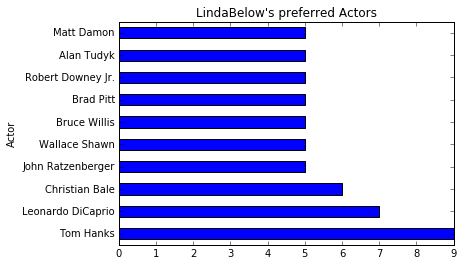

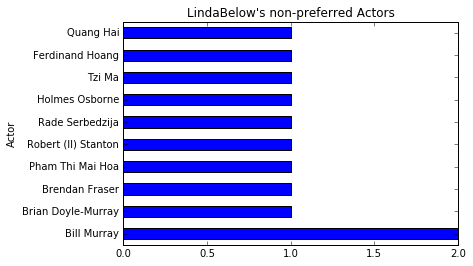

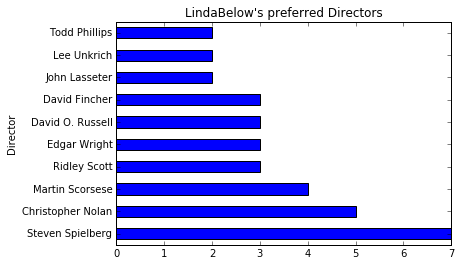

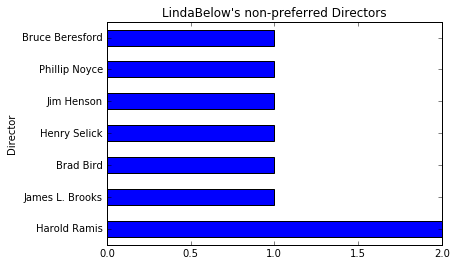

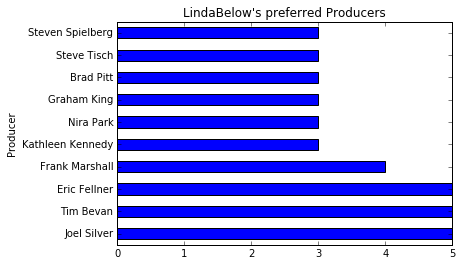

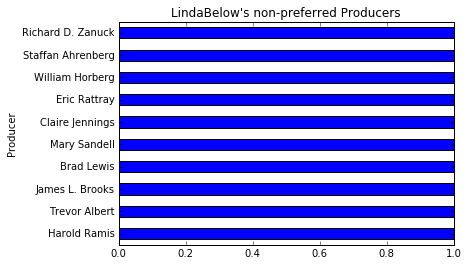

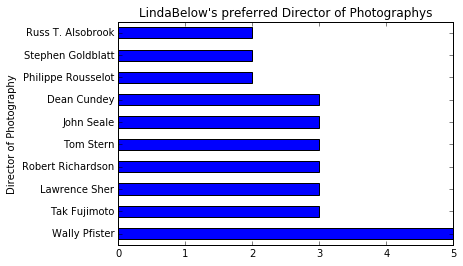

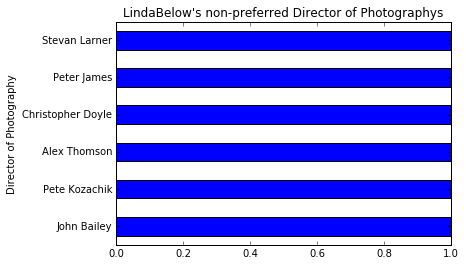

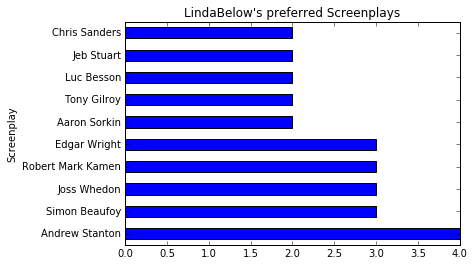

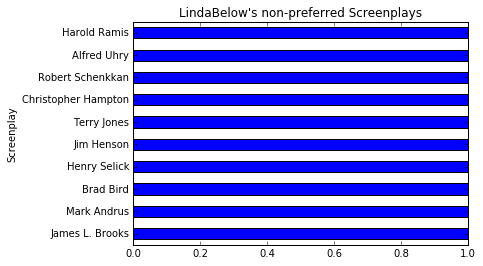

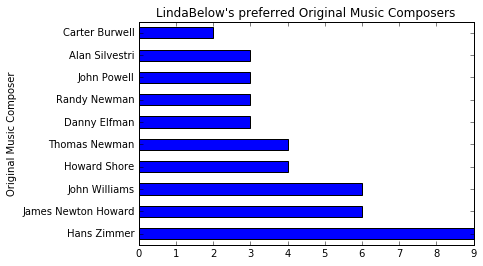

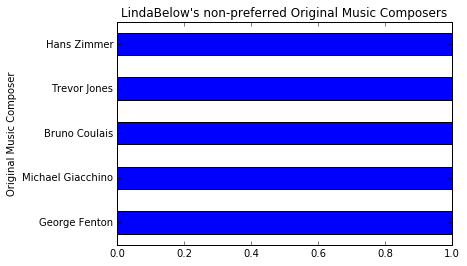

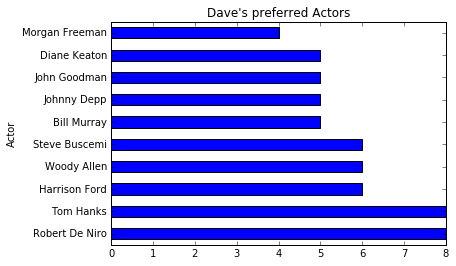

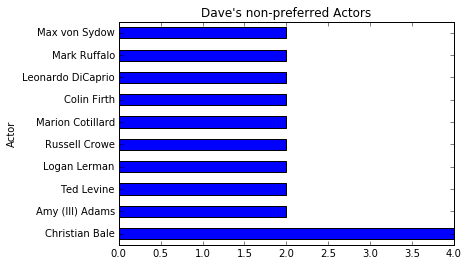

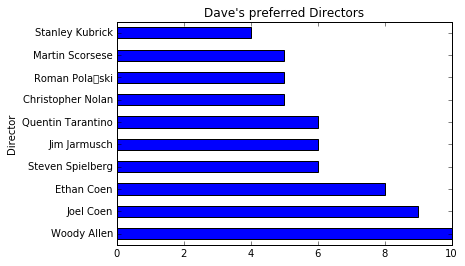

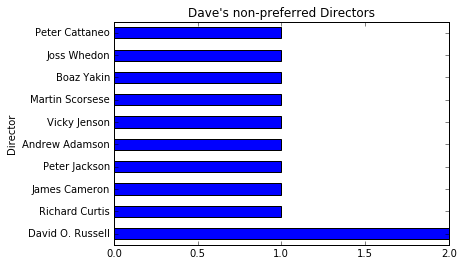

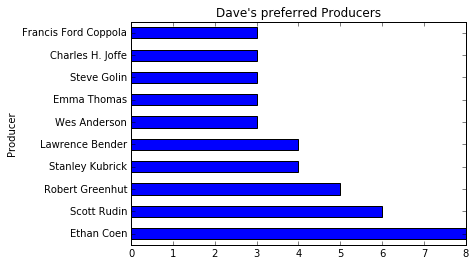

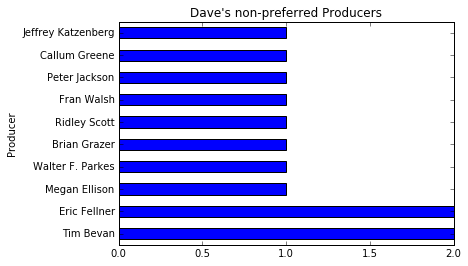

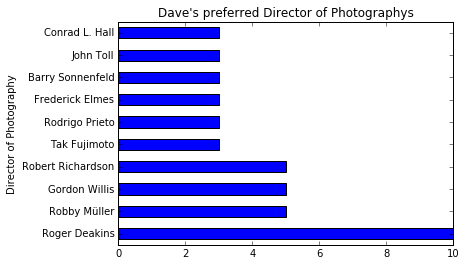

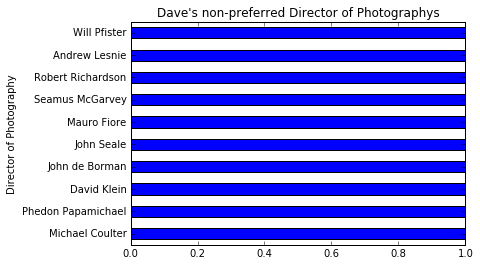

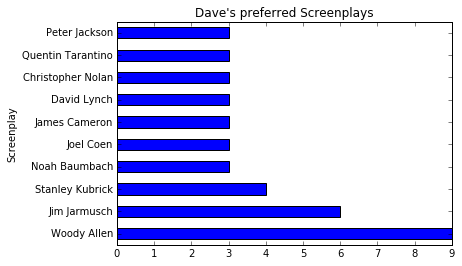

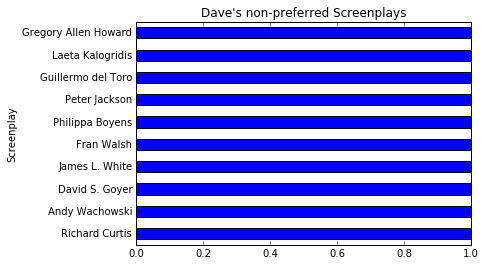

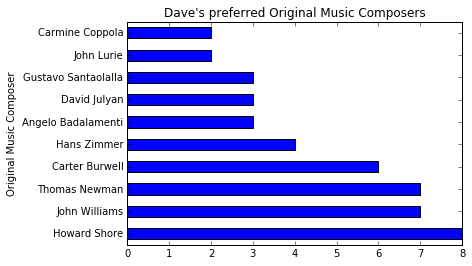

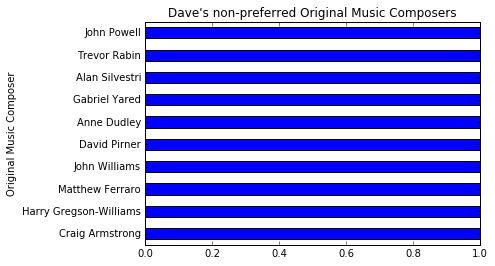

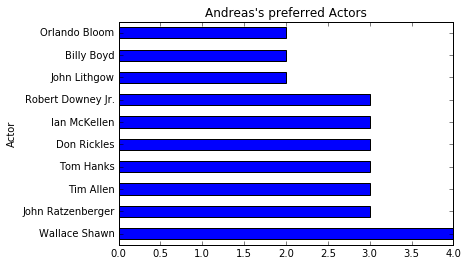

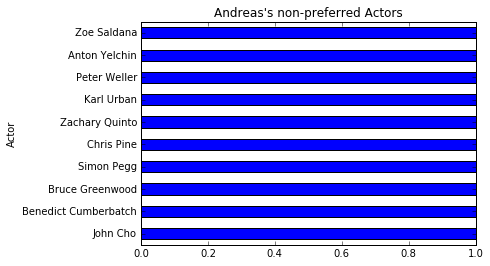

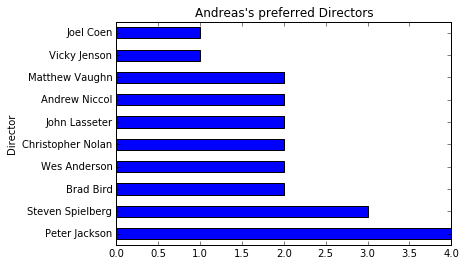

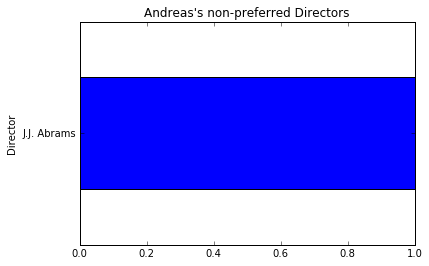

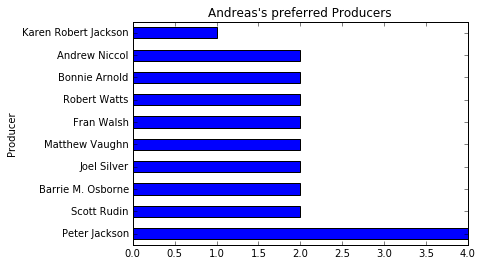

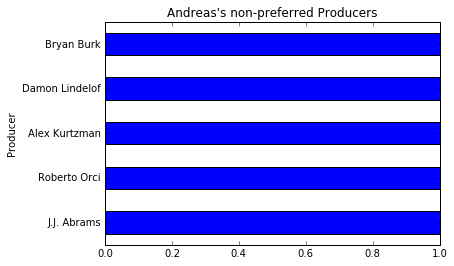

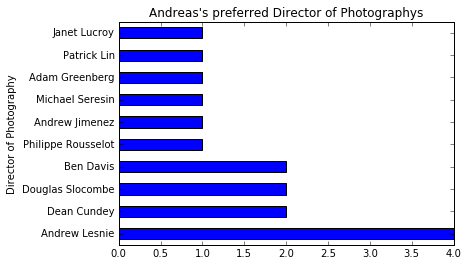

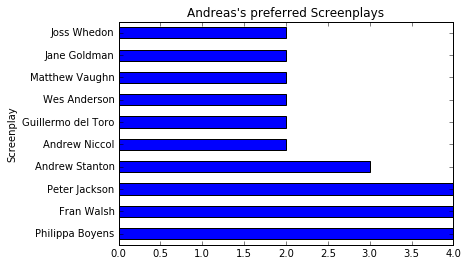

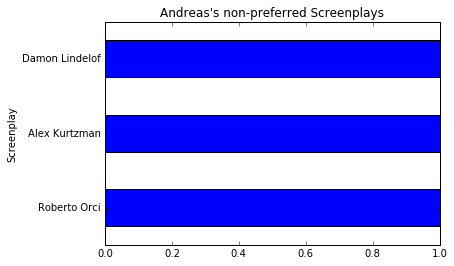

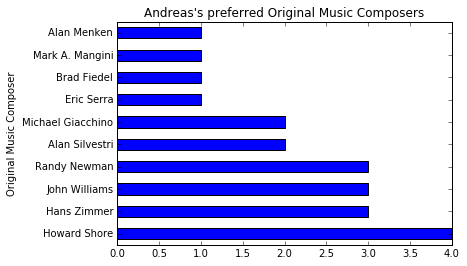

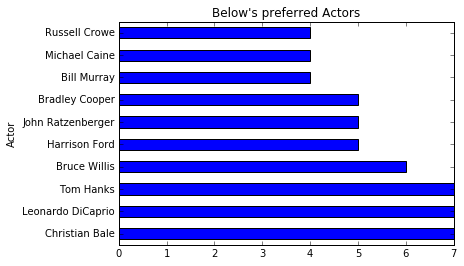

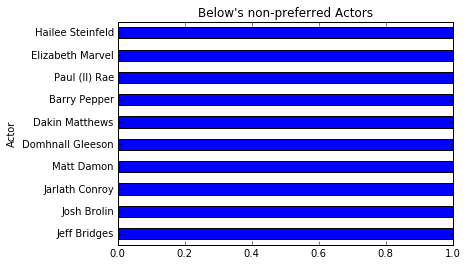

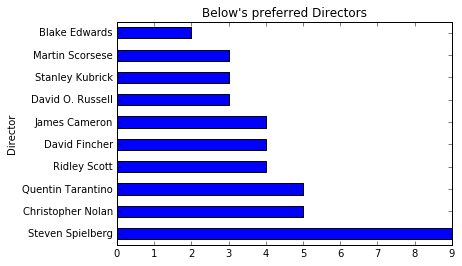

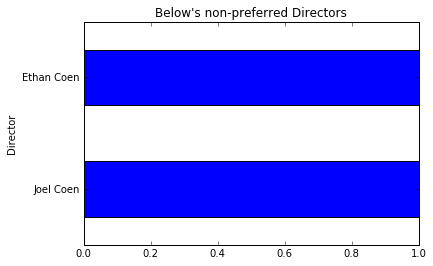

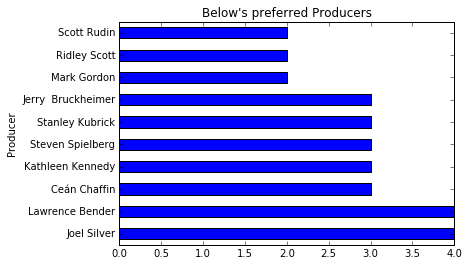

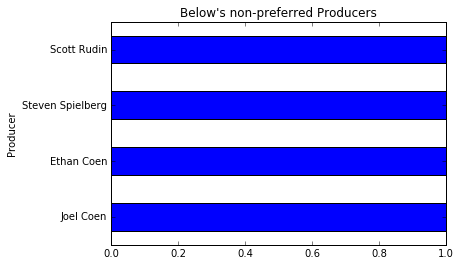

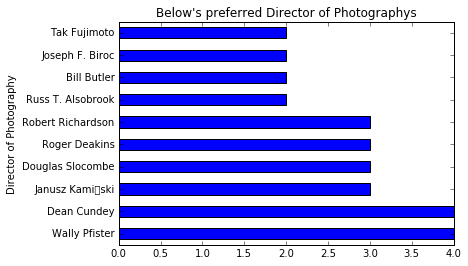

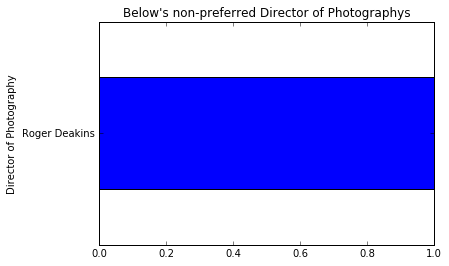

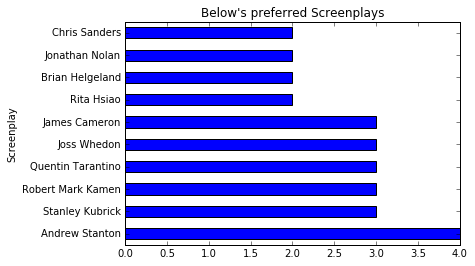

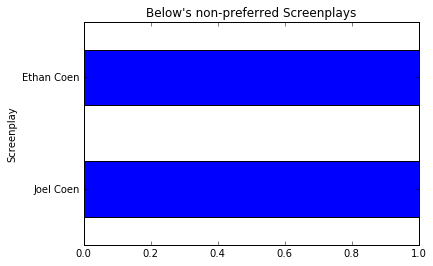

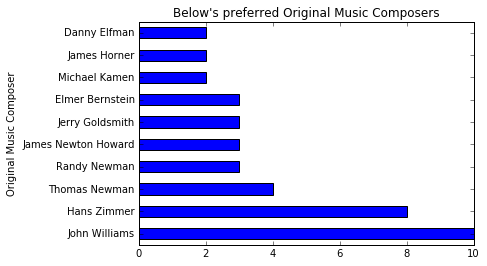

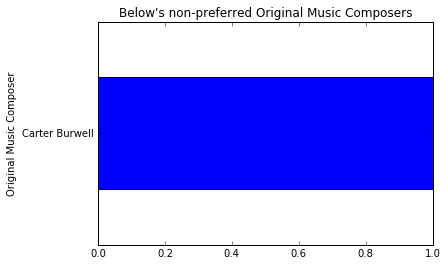

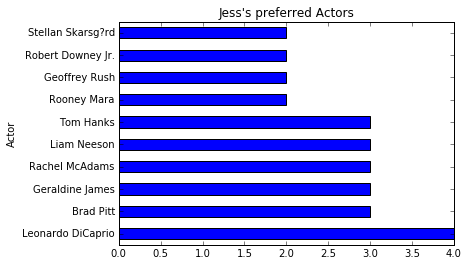

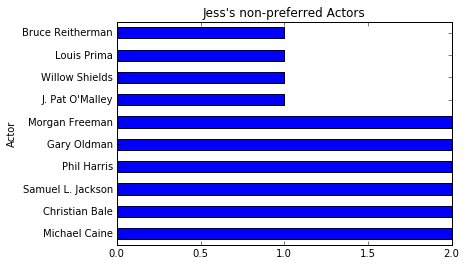

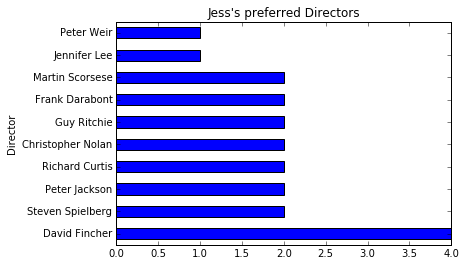

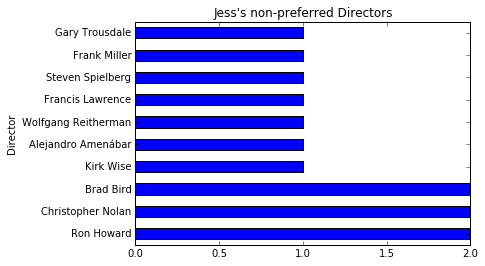

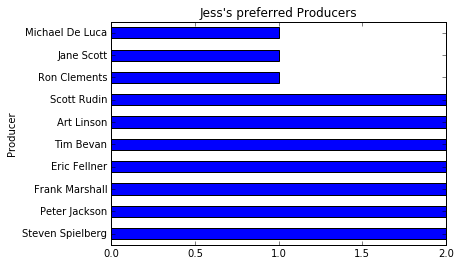

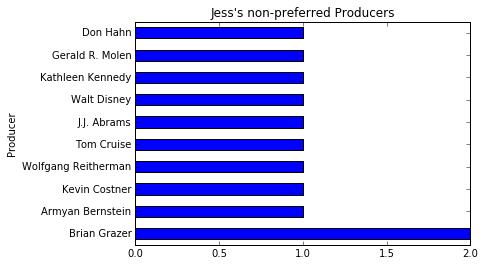

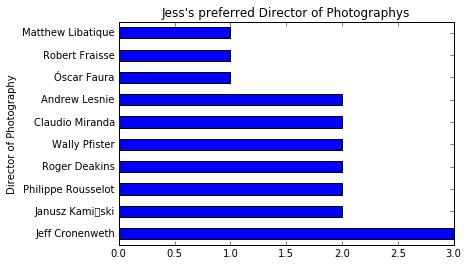

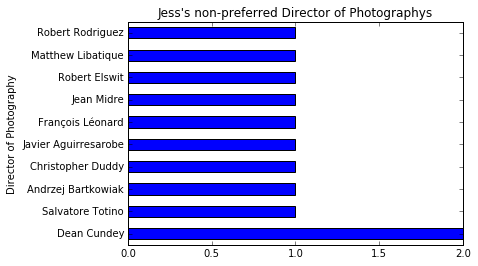

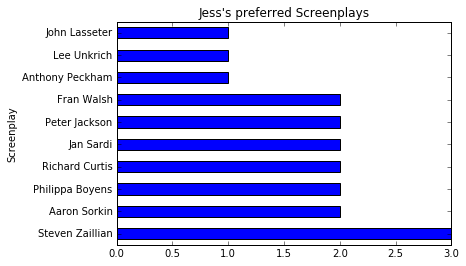

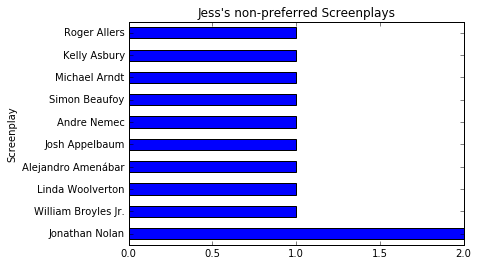

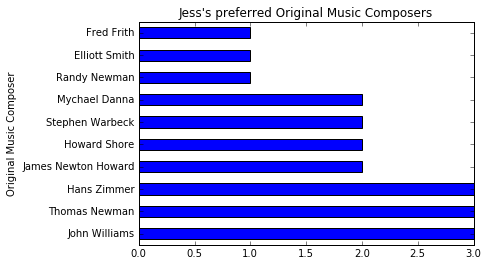

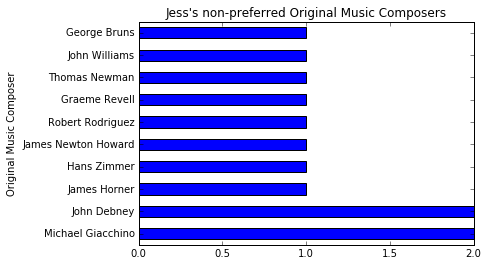

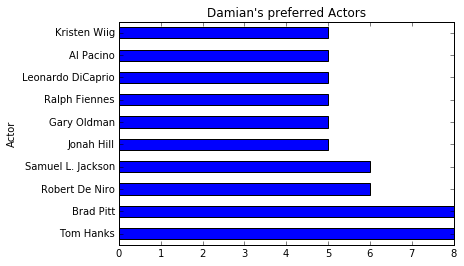

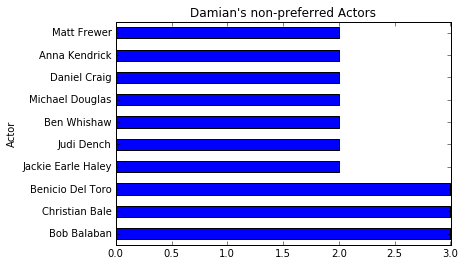

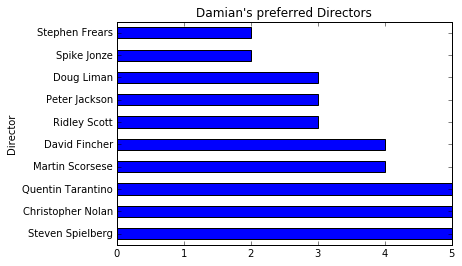

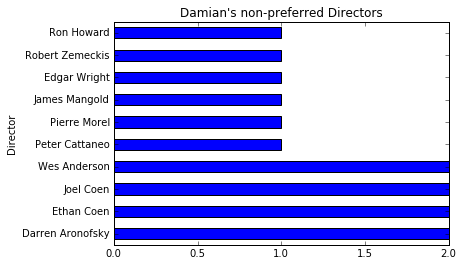

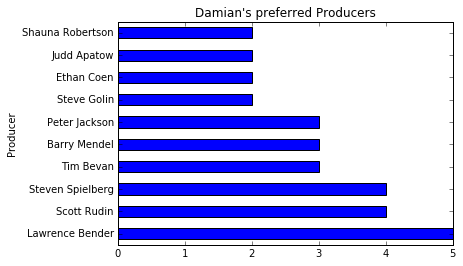

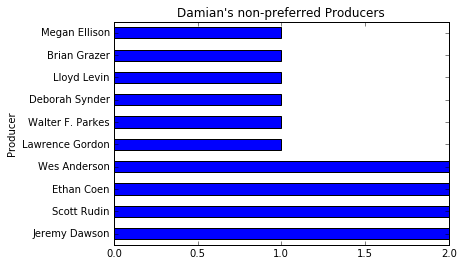

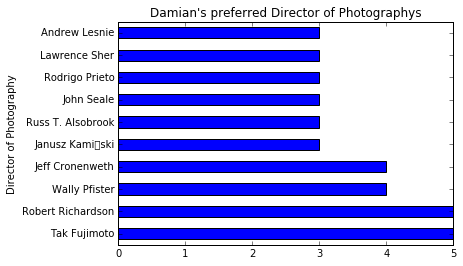

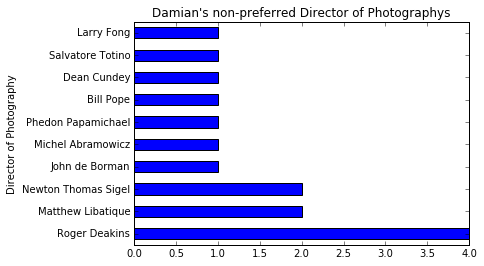

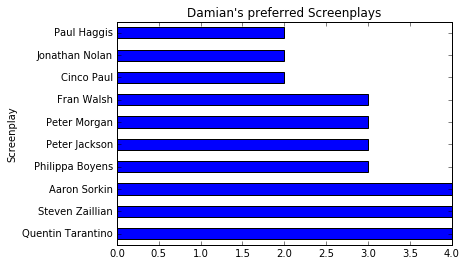

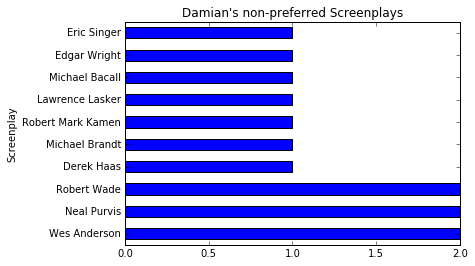

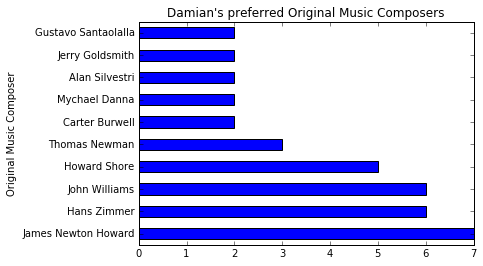

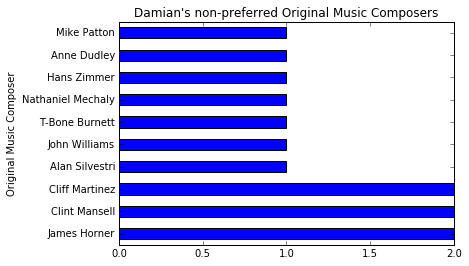

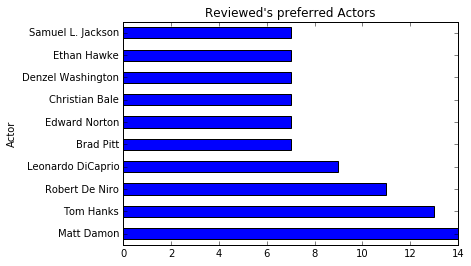

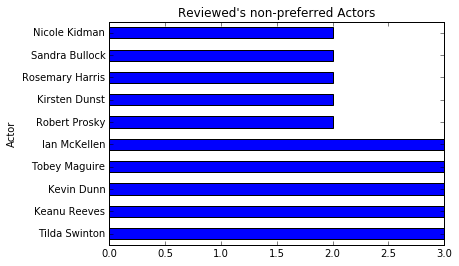

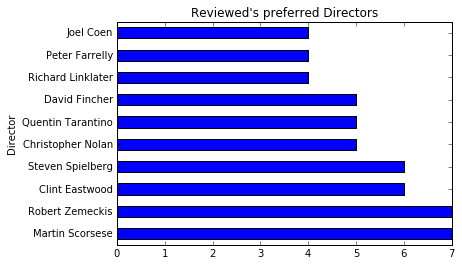

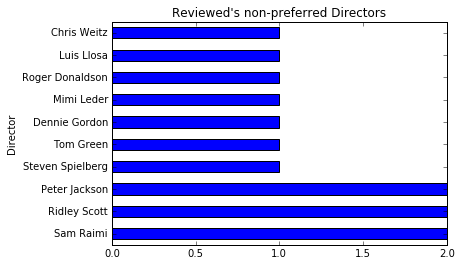

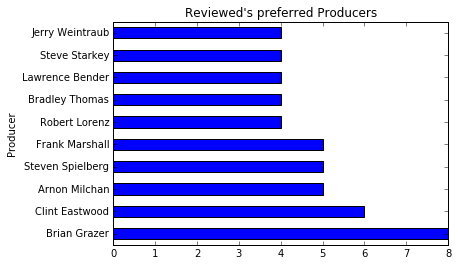

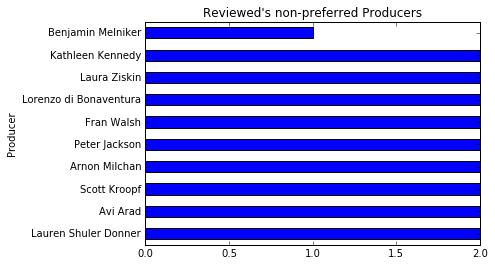

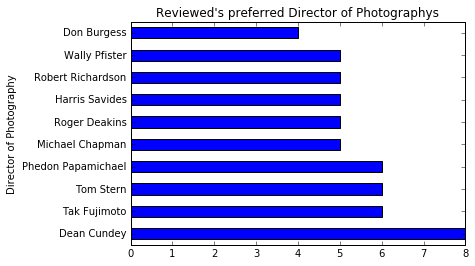

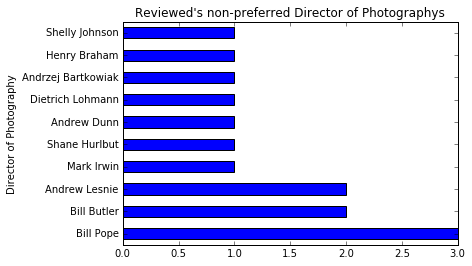

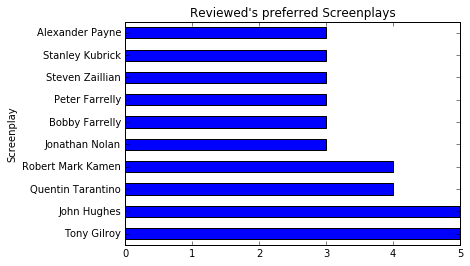

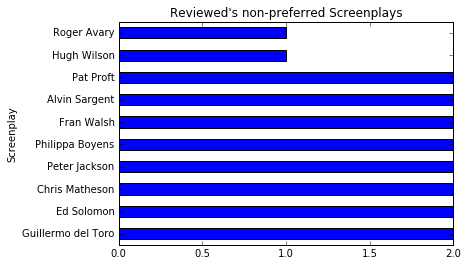

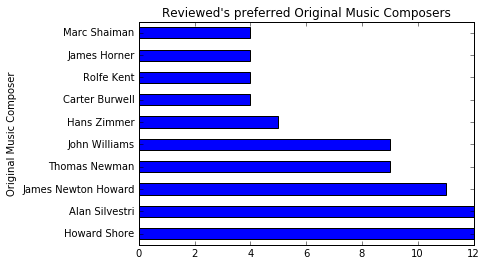

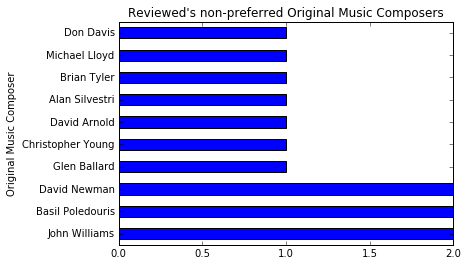

In [176]:
# Display Top Preferred and Non-Preferred features for new users
test_features = ['Actor','Director', 'Producer', 'Director of Photography', 'Screenplay', 'Original Music Composer']

for sheet, usrs in users.iteritems():
    for usr in usrs:
        for feature in test_features:
            graph_top_discrete_features(sheet, usr, feature, 10, bad_films = False)
            graph_top_discrete_features(sheet, usr, feature, 10, bad_films = True)

**Linear regression on film attributes - per new user**

,Films_Barker Andreas,Films_Barker Below,Films_Barker Dave,Films_Barker LindaBelow,Films_Barton Damian,Films_Barton Jess,Films_Justin Reviewed
All_feats_R^2_Test,-0.946582,0.304251,-0.093231,0.078181,-0.093206,0.328110,0.188572
All_feats_R^2_Train,0.258621,0.315867,0.152028,0.177945,0.089889,0.206357,0.377914
Films_rated,51.000000,154.000000,331.000000,189.000000,263.000000,107.000000,657.000000
budget_R^2_Test,-0.207619,-0.006655,-0.067602,-0.028672,-0.028946,-0.211486,0.007592
budget_R^2_Train,0.216796,0.000419,0.125005,0.002812,0.001429,0.209598,0.094630
num_ratings_R^2_Test,-0.036683,-0.007685,-0.004935,-0.068759,-0.088143,0.066990,0.142063
num_ratings_R^2_Train,0.023863,0.010257,0.007364,0.007069,0.004059,0.011987,0.079427
rating_R^2_Test,-0.432089,0.379714,-0.002435,0.025328,-0.148113,-0.049048,0.334248
rating_R^2_Train,0.000117,0.218169,0.018898,0.010183,0.004462,0.022108,0.251684
revenue_R^2_Test,-0.093742,0.033713,0.048947,0.062356,0.004955,-0.175181,0.000204


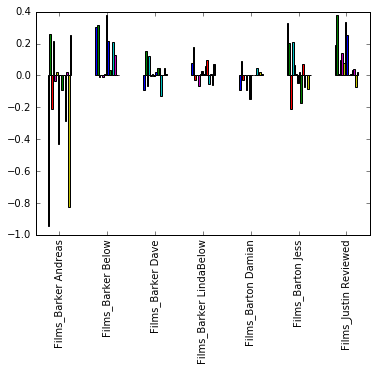

In [177]:
# Create Linear Regression Models for each user, using only continuous variables
# that are film attributes
# For each user:
# Try a model with all feaures, and a model with each feature individually
import sklearn
from sklearn.linear_model import LinearRegression
test_features = ['year','num_ratings','rating','runtime', 'budget', 'revenue']
results = {}
for sheet, usrs in users.iteritems():
    for usr in usrs:
        
        # Results table
        sheet_user = '%s %s' % (sheet, usr)
        results[sheet_user] = {}
        
        # Create dataframe, and show number of films rated
        df = users[sheet][usr]
        results[sheet_user]['Films_rated'] = len(df)

        df = add_features(df, test_features)
        # Make sure each feature has a value in every row
        for feat in test_features:
            df = df[df[feat].notnull()]
            
        # Linear regression on all features
        X_train, X_test, Y_train, Y_test = sklearn.cross_validation.train_test_split(
            df[test_features], df['out of 10'])
        lm = LinearRegression()
        lm.fit(X_train, Y_train)

        results[sheet_user]['All_feats_R^2_Train'] = lm.score(X_train, Y_train)
        results[sheet_user]['All_feats_R^2_Test'] = lm.score(X_test, Y_test)
            
        # Linear regression on features individually
        for feature in test_features:
            X_train, X_test, Y_train, Y_test = sklearn.cross_validation.train_test_split(
            df[[feature]], df['out of 10'])
            lm = LinearRegression()
            lm.fit(X_train, Y_train)
            
            results[sheet_user]['%s_R^2_Train' % feature] = lm.score(X_train, Y_train)
            results[sheet_user]['%s_R^2_Test' % feature] = lm.score(X_test, Y_test)
            
df = pd.DataFrame(results).transpose().drop(['Films_rated'], axis = 1).plot(kind='bar', legend = False)
pd.DataFrame(results)

**Linear regression on old user ratings - per new user**

In [178]:
# For new user defined by [sheet_name][user_name], find all historial users, who have rated the same films
# Add these users and their ratings as new columns to Dataframe df returned (indentified as UserId)  
# Count the number of films, historical users and new user have both rated.
# Optional parameters:
# only_match_good: only find historial users that match on good films
# max_num_users: the maximum number of users to return
# min_common_films: the minimum number of shared rated films, 
#    from new user to old user to include in df
def find_hist_users(sheet_name, user_name, only_match_good = False, max_num_users = pd.np.Inf, min_common_films = -pd.np.Inf):
    global old_rats
    usr = users[sheet_name][user_name] # new user ratings
    
    # Retain only good films from new and old users (if applicable)
    if only_match_good:
        usr = usr[ usr['out of 10'] >= good_films_threshold ]
        old_rats = old_rats[old_rats['user_rating'] >= good_films_threshold]
    
    # Merge new user ratings, with old
    df = old_rats.merge(usr, left_on = 'index', right_on = 'index')
    df.drop_duplicates(inplace = True)
    
    # Count the number common films reviwed between new user, and old users
    gb = df[['userId', 'index']].groupby('userId').count()
    gb.rename(columns={'index':'common_films_count'}, inplace = True)
    
    # Remove old users that did not hit the min_common_films threshold
    gb = gb[gb['common_films_count'] >= min_common_films]
    gb.reset_index(inplace = True)
    gb.sort_values(by = 'common_films_count', ascending = False, inplace = True)
    
    # Create final dataframe, and cut off at the maximum number of users to find
    gb = gb.head(min(len(gb), max_num_users))
    df = gb.merge(df)

    return df

In [179]:
# Convert hist_users_with_new into a user features dataframe. (used after find_hist_users)
# hist_users_with_new must have columns:
# 'index' - film indentifer
# 'userId' - historial user indentifier
# 'user_rating' - historal user_rating
# 'out of 10' - new user rating
# 'common_films_count' - the  number of shared rated films, from new user to old user
# New columns names added will be 'userId', for all userIds
# The number of new columns added will be capped by:
# max_features - the maximum number of userId_d columns to add
def create_hist_user_features(hist_users_with_new, max_features = pd.np.Inf):
    df = hist_users_with_new
    df = df[['userId', 'common_films_count']]
    df.drop_duplicates(inplace = True)
    df.sort_values(by = 'common_films_count', ascending = False, inplace = True)
    feats = df.head(min(len(df),max_features))[['userId']]
    
    df = hist_users_with_new.merge(feats, left_on = 'userId', right_on = 'userId')
    
    df = df[['index', 'userId','user_rating','out of 10']]
    return df
    

In [180]:
# Perform pivot table, with normal pandas fields: 'values', 'index', 'column'
# Remove na values in pivot table, then..
# Add columns 'keep_cols' in the final table, whose values correspond with 'index'
#   Note: the 'keep_cols' are NOT pivoted, and can't be part of 'columns'
# If dropna == True, will make sure all features have a value 
#   Note: to be used when running directly in a regression model
def pivot_and_keep_cols(df, values, index, columns, keep_cols = [], dropna = True):
    piv = df.pivot_table(values = 'user_rating', index = 'index', columns = 'userId')
    if dropna:
        piv.dropna(inplace = True)
    df = piv.merge(df[keep_cols+[index]], left_index = True, right_on = index)
    return df.drop_duplicates()

In [181]:
# Run multiple linear regression models for each new user, on old users ratings as features
# Same field descriptions as above, store results in 'results'
def run_linreg_hist_users(sheet_name, user_name, max_num_users, only_match_good, results):
    # Transform the data
    df = find_hist_users(sheet_name = sheet_name, user_name = user_name, 
                         max_num_users = max_num_users, only_match_good = only_match_good)
    df = create_hist_user_features(df)
    df = pivot_and_keep_cols(df, values = 'user_rating', index = 'index', columns = 'userId', keep_cols = ['out of 10'])
    
    # Run the linear regression
    feats = df.drop(['out of 10', 'index'], axis = 1)
    test_score = pd.np.nan
    train_score = pd.np.nan
    if len(feats) >= 2: # Only run linear regression if there is enough data to do so
        X_train, X_test, Y_train, Y_test = sklearn.cross_validation.train_test_split(
                feats, df['out of 10'])
        lm = LinearRegression()
        lm.fit(X_train, Y_train)
        test_score = lm.score(X_test, Y_test)
        train_score = lm.score(X_train, Y_train)
    
    # Store the results
    results.append({'User':'%s %s'%(sheet_name, user_name), 
                   'Amount rated by user':len(users[sheet_name][user_name]),
                   'Amount of old users':feats.shape[1],
                   'Amount of films in common':feats.shape[0],
                   'Good films only':only_match_good, 
                   'R^2_Train':train_score,
                   'R^2_Test':test_score})
    
    return results


In [182]:
# Run linear regression models for all users, against previous users, tweaking both:
#   number of users to use as features (dimensions, d), 
#   and only finding users that match on good films or not
%time
results = []
result_fields = ('User', 'Amount rated by user', 'Amount of old users', 'Amount of films in common',
                 'Good films only', 'R^2_Train', 'R^2_Test')
dimensions = [1, 2, 5, 10, 20, 50, 100, 200, 500]
for sheet, usrs in users.iteritems():
    for usr in usrs:
        for d in dimensions:
            run_linreg_hist_users(sheet, usr, max_num_users = d, only_match_good = True, results = results)
            run_linreg_hist_users(sheet, usr, max_num_users = d, only_match_good = False, results = results)
df = pd.DataFrame(results, columns = result_fields)
mult_lin_reg_old_users = df
df

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.11 µs


,User,Amount rated by user,Amount of old users,Amount of films in common,Good films only,R^2_Train,R^2_Test
0,Films_Barker LindaBelow,189,1,130,True,0.024818,0.062029
1,Films_Barker LindaBelow,189,1,158,False,0.008466,-0.067177
2,Films_Barker LindaBelow,189,2,111,True,0.053505,0.002457
3,Films_Barker LindaBelow,189,2,135,False,0.037591,-0.274349
4,Films_Barker LindaBelow,189,5,78,True,0.087753,-0.068860
5,Films_Barker LindaBelow,189,5,94,False,0.114663,-0.188557
6,Films_Barker LindaBelow,189,10,56,True,0.192782,-0.767375
7,Films_Barker LindaBelow,189,10,57,False,0.358906,-0.793148
8,Films_Barker LindaBelow,189,20,23,True,1.000000,-30.383492
9,Films_Barker LindaBelow,189,20,27,False,1.000000,-712.340950


In [208]:
# Show the R^2 scores distribution for each users
mult_lin_reg_old_users[['User', 'Amount rated by user', 'R^2_Train', 'R^2_Test']].groupby(['User', 'Amount rated by user']).describe()

R^2_Test  R^2_Train
User                    Amount rated by user                             
Films_Barker Andreas    51                   count   12.000000  12.000000
                                             mean    -2.646864   0.500902
                                             std      4.890542   0.422835
                                             min    -16.853163   0.044251
                                             25%           NaN        NaN
                                             50%           NaN        NaN
                                             75%           NaN        NaN
                                             max      1.000000   1.000000
Films_Barker Below      154                  count   14.000000  14.000000
                                             mean    -0.672296   0.468655
                                             std      1.321154   0.435006
                                             min     -4.556207   0.006015
                                             25%           NaN        NaN
                                             50%           NaN        NaN
                                             75%           NaN        NaN
                                             max      0.165805   1.000000
Films_Barker Dave       331                  count   12.000000  12.000000
                                             mean    -0.049265   0.319033
                                             std      0.375584   0.381777
                                             min     -0.510247   0.000824
                                             25%           NaN        NaN
                                             50%           NaN        NaN
                                             75%           NaN        NaN
                                             max      0.958468   1.000000
Films_Barker LindaBelow 189                  count   12.000000  12.000000
                                             mean   -62.079967   0.406540
                                             std    204.962948   0.448076
                                             min   -712.340950   0.008466
                                             25%           NaN        NaN
                                             50%           NaN        NaN
                                             75%           NaN        NaN
                                             max      0.577563   1.000000
Films_Barton Damian     263                  count   13.000000  13.000000
                                             mean    -0.662602   0.426106
                                             std      1.710451   0.428935
                                             min     -6.131551   0.000380
                                             25%           NaN        NaN
                                             50%           NaN        NaN
                                             75%           NaN        NaN
                                             max      0.198761   1.000000
Films_Barton Jess       107                  count   12.000000  12.000000
                                             mean    -0.483890   0.530007
                                             std      0.853246   0.446716
                                             min     -2.521117   0.004108
                                             25%           NaN        NaN
                                             50%           NaN        NaN
                                             75%           NaN        NaN
                                             max      0.266812   1.000000
Films_Justin Reviewed   657                  count   12.000000  12.000000
                                             mean    -1.236078   0.417610
                                             std      3.267674   0.430855
                                             min    -11.303985   0.012345
                                             25%          

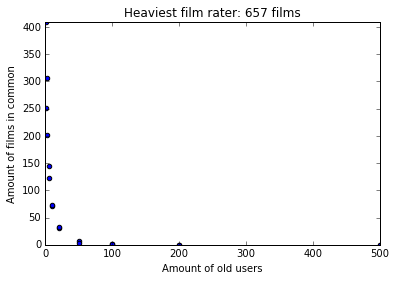

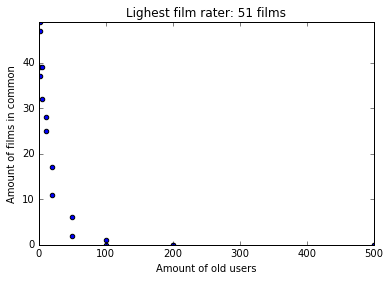

In [183]:
# Plot the heaviest and the lightest film raters, to see how many old users have also rated these films
heaviest = df[df['User'] == 'Films_Justin Reviewed']
heaviest.plot(kind = 'scatter', x = 'Amount of old users', 
    y = 'Amount of films in common', title = 'Heaviest film rater: %s films' % len(users['Films_Justin']['Reviewed']),
    xlim = (0,max(heaviest['Amount of old users'])), ylim = (0,max(heaviest['Amount of films in common'])))

lightest = df[df['User'] == 'Films_Barker Andreas']
lightest.plot(kind = 'scatter', x = 'Amount of old users', 
    y = 'Amount of films in common', title = 'Lighest film rater: %s films' % len(users['Films_Barker']['Andreas']),
    xlim = (0,max(lightest['Amount of old users'])), ylim = (0,max(lightest['Amount of films in common'])))

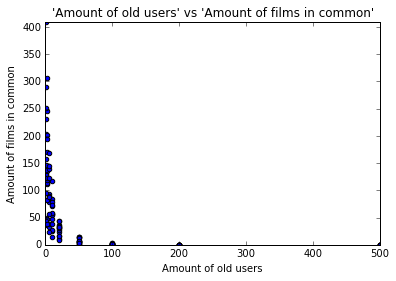

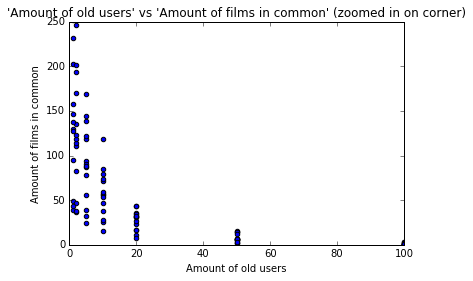

In [184]:
# Plot the relationship between number of 'Amount of old users' vs 'Amount of films in common' across the board
df.plot(kind = 'scatter', x = 'Amount of old users', 
    y = 'Amount of films in common', title = "'Amount of old users' vs 'Amount of films in common'",
    xlim = (0,max(df['Amount of old users'])), ylim = (0,max(df['Amount of films in common'])))
df.plot(kind = 'scatter', x = 'Amount of old users', 
    y = 'Amount of films in common', title = "'Amount of old users' vs 'Amount of films in common' (zoomed in on corner)",
    xlim = (0,100), ylim = (0,250))

**Finding old users with similar ratings to new users**

In [185]:
# For each new user, find similar users from on old users ratings
# Same field descriptions as above
# Tolerance - how close as ratio difference, must both the mean and std of new user ratings be to be included
# results dictionary 'similiar_users' of dataframes indexed by 'sheet_name user_name'
def find_similar_hist_users(sheet_name, user_name, max_num_users, only_match_good, tolerance, similiar_users):
    
    df = find_hist_users(sheet_name, user_name, max_num_users = max_num_users, only_match_good = only_match_good)
    df = create_hist_user_features(df)
    
    df = pivot_and_keep_cols(df, values = 'user_rating', index = 'index', columns = 'userId', 
                          keep_cols = ['out of 10'], dropna = False)

    # List to store the results
    results = pd.DataFrame()

    # Loop through all old users, and record how similar their scores are based on: mean, median, std etc
    old_users = list(df.columns)[:-2]
    for u in old_users:
        df1 = df[df['out of 10'].notnull()&df[u].notnull()][['out of 10', u]].describe().transpose()
        df1.rename(index = {u:'userId'}, inplace = True)
        df1 = pd.DataFrame(df1.unstack()).transpose()
        df1.rename(index = {0:u}, inplace = True)
        results = results.append(df1)
    
    # Add 'diff' values to compare the results - (linking back to the tolerance above)
    results['mean', 'diff'] = abs((results['mean', 'out of 10'] - results['mean', 'userId'])/results['mean', 'out of 10'])
    results['std', 'diff'] = abs((results['std', 'out of 10'] - results['std', 'userId'])/results['std', 'out of 10'])
    
    # Remove those outside of the tolerance
    results = results[ results['mean', 'diff'] <= tolerance ]
    results = results[ results['std', 'diff'] <= tolerance ]
    
    # Sort results and save
    results.sort_values(by = [('std', 'diff'), ('mean', 'diff')])
    similiar_users['%s %s' % (sheet_name, user_name)] = results

In [186]:
# Find the most similar raters for each user
# This takes ages and/or locks up the computer, so it won't be run all the time.
have_good_computer = False
similiar_users = {}
if have_good_computer:
    for sheet, usrs in users.iteritems():
        for usr in usrs:
            find_similar_hist_users(sheet, usr, max_num_users = pd.np.Inf, only_match_good = True, 
                tolerance = 0.05, similiar_users = similiar_users)
            
# Instead do this for a single user:
find_similar_hist_users('Films_Justin', 'Reviewed', max_num_users = 200, only_match_good = True, 
                tolerance = 0.10, similiar_users = similiar_users)
similiar_users['Films_Justin Reviewed']

count             mean                 std                 min  \
userId out of 10 userId out of 10    userId out of 10    userId out of 10   
2669       184.0  184.0  7.413043  7.869565  0.594183  0.639627       7.0   
33575      162.0  162.0  7.456790  7.728395  0.611472  0.610719       7.0   
52260      165.0  165.0  7.393939  7.606061  0.611844  0.650487       7.0   
91349      158.0  158.0  7.455696  7.683544  0.624295  0.608733       7.0   
110847     178.0  178.0  7.320225  7.898876  0.556153  0.563383       7.0   
114270     157.0  157.0  7.369427  7.675159  0.602203  0.612022       7.0   
118205     209.0  209.0  7.363636  7.928230  0.581624  0.604166       7.0   

                    25%              50%              75%              max  \
userId userId out of 10 userId out of 10 userId out of 10 userId out of 10   
2669      7.0       7.0    7.0       7.0    8.0       8.0    8.0       9.0   
33575     7.0       7.0    7.0       7.0    8.0       8.0    8.0       9.0   
52260     7.0       7.0    7.0       7.0    8.0       8.0    8.0       9.0   
91349     7.0       7.0    7.0       7.0    8.0       8.0    8.0       9.0   
110847    7.0       7.0    8.0       7.0    8.0       8.0    8.0       9.0   
114270    7.0       7.0    7.0       7.0    8.0       8.0    8.0       9.0   
118205    7.0       7.0    8.0       7.0    8.0       8.0    8.0       9.0   

                   mean       std  
userId userId      diff      diff  
2669     10.0  0.061584  0.076483  
33575    10.0  0.036424  0.001231  
52260    10.0  0.028689  0.063159  
91349     9.0  0.030560  0.024928  
110847   10.0  0.079048  0.012999  
114270   10.0  0.041487  0.016305  
118205   10.0  0.076673  0.038757

In [187]:
# From Justin's similar users above, find films these users have rating as good films
# These will form the basis for the first recommendations

LAF_threshold = 8 # Life altering film threshold (score out of 10)

# Get just the 'userId's of all of the old users who are similar
df = similiar_users['Films_Justin Reviewed']
df.drop(list(df.columns), axis = 1, inplace = True)

# Find LAFs from these similar users
df = old_rats.merge(df, left_on = 'userId', right_index = True)
df = df[df['user_rating'] >= LAF_threshold]
df = df[['index']]
df.drop_duplicates(inplace = True)
df = films_all.merge(df, left_on = 'index', right_on = 'index')[['title', 'year', 'genres', 'lead actor','index']]

# Remove films I've already seen, and display results
tmp = df[['index']].merge(users['Films_Justin']['Reviewed'][['title','index']], left_on = 'index', right_on = 'index', how='left')
unwatched_films = tmp[tmp['title'].isnull()][['index']]
recommendations = unwatched_films.merge(df, left_on = 'index', right_on = 'index')
recommendations.drop_duplicates(subset = ['title', 'year'])

,index,title,year,genres,lead actor
0,203878,The Replacements,2000,Comedy,Keanu Reeves
1,19974,Transformers: Revenge of the Fallen,2009,Action|Adventure|Sci-Fi|IMAX,Shia LaBeouf
2,50556,Bigger Than Life,1956,Drama|Mystery|Thriller,James Mason
3,749,High Noon,1952,Drama|Western,Gary Cooper
4,221052,The Greatest Show on Earth,1952,Drama,Betty Hutton
5,94358,Being There,1979,Comedy|Drama,Peter Sellers
6,93350,Patton,1970,Drama|War,George C. Scott
7,10839,The Borrowers,1997,Adventure|Children|Comedy|Fantasy,John Goodman
8,201720,Stanley & Iris,1990,Drama|Romance,Jane Fonda
9,18052,Tender Mercies,1983,Drama|Romance|Western,Robert Duvall
